## Булгаков Арсений

# l-1 trend filtering (18 pts)

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Задание:
1. (1 pts.) Скачайте тестовые данные: данные о цене закрытия акций российских финансовых компаний (например, с finam.ru). Это ваши тестовые данные. 
2. (3 pts.) Выпишите двойственную задачу для задачи Trend Filter.
3. (3 pts.) Численно решите задачу Trend Filter используя одну из версий проксимального градиентного спуска.
4. (5 pts.) Выпишите сглаженную версию задачи Trend Filter и найдите ее решение используя метод быстрого градиентного спуска (версия из лекции про сглаживание).
5. (4 pts.) Выпишите схему ADMM для решения задачи Trend Filter, реализуйте ее и найдите численное решение задачи. 
6. (2 pts.) Сравните полученные результаты на тестовых данных.

In [ ]:
# Место для вашего решения

: 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
import cvxpy as cp
import scipy as scipy
import cvxopt as cvxopt

### 1).

In [6]:
data = pd.read_csv('/Users/arsenij/Downloads/VTBR_190205_210205.csv')
data = data.loc[:,["<DATE>", "<CLOSE>"]]
data = data.rename(columns={"<DATE>": "date", "<CLOSE>": "price"})
data["date"] = pd.to_datetime(data["date"])

In [7]:
data

,date,price
0,2019-02-05,0.038210
1,2019-02-06,0.037610
2,2019-02-07,0.037010
3,2019-02-08,0.037130
4,2019-02-11,0.037600
...,...,...
499,2021-02-01,0.036945
500,2021-02-02,0.036945
501,2021-02-03,0.037000
502,2021-02-04,0.037380


Text(0, 0.5, 'Цена')

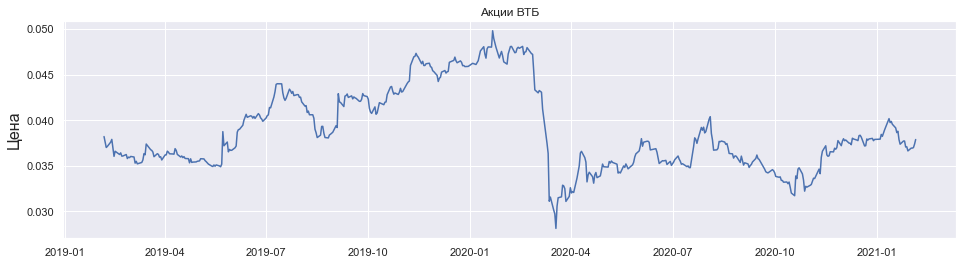

In [8]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(data["date"], data["price"])
ax.set_title("Акции ВТБ")
ax.set_ylabel('Цена', fontsize=16)

### 2).

Исходная задача:

$ \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 \rightarrow \min\limits_{x \in R^T} $
 
$ s.t. \ Dx = z$

Лагранжиан $L = \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 + \nu^T(Dx-z) = ((D^T\nu)^Tx + \frac{1}{2}\|y - x\|_2^2)$
$- (\nu^Tz - \lambda \|z\|_1)$

$f(x) = (D^T\nu)^Tx + \frac{1}{2}\|y - x\|_2^2 \rightarrow \min\limits_{x \in R^T}$

$\nabla f(x) = D^T\nu - y + x = 0 \Rightarrow x_* = y - D^T\nu$
$\Rightarrow \min\limits_x f(x) = (D^T\nu)^T(y-D\nu) + \frac{1}{2}\|D\nu\|_2^2 =  y^T D^T\nu - \frac{1}{2}\|D\nu\|_2^2$

$\inf\limits_{z} -(\nu^Tz - \lambda \|z\|_1) = -\sup\limits_{z} (\nu^Tz - \lambda \|z\|_1) = $
$-\lambda \sup\limits_{z} (\frac{1}{\lambda}\nu^Tz - \|z\|_1) \begin{equation*}
 = 
 \begin{cases}
   0 &\text{$\|\nu\|_{\infty} \leq \lambda$}\\
   -\infty &\text{иначе}
 \end{cases}
\end{equation*}$



Следовательно, двойственная задача имеет вид:

$g(\nu) = \frac{1}{2} \| D^T \nu \|_2^2 - y^T D^T \nu \rightarrow \min\limits_{\nu}$

$s.t. |\nu_i| \leq \lambda \ \ \forall i$

### 3).

Исходная задача: $\frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 \rightarrow \min\limits_{x \in R^T}$

$prox_{\mu}(v) = \operatorname*{argmin}\limits_\theta (\frac{\mu}{2}\|\theta - v\|_2^2 + \lambda \|\theta\|_1)$

То есть для того, чтобы посчитать проксимальный опреатор, нужно решить задачау, аналогичную исходной. Поэтому для исходной задачи использование прокисмального градиентного спуска не имеет смысла

Но заметим, что целевая функция выпуклая, ограничения типа равенств линейные, а ограничений неравенств нет, значит выполнено условие Слейтера, следовательно есть сильная двойственность. Тогда вместо исходной задачи можем решить 
двойственную. При этом решения прямой и двойственной задач связаны соотношением:
$x_* = D^T \nu_*$


Двойственную задачу как раз будем решать проксимальным градиентным спуском

$f(\nu) + g(\nu) = \frac{1}{2} \| D^T \nu \|_2^2 - y^T D^T \nu + \mathbb{1}(-\lambda \textbf{1} \leq \nu \leq \lambda \textbf{1})$
$\rightarrow \min\limits_{\nu}$


$\nabla f(\nu) = D D^T \nu - D y$

$prox_{\mu, g}(v) = \operatorname*{argmin}\limits_\theta (\frac{\mu}{2}\|\theta - v\|_2^2 + \mathbb{1}(-\lambda \textbf{1} \leq \theta \leq \lambda \textbf{1})) = \begin{bmatrix}
\operatorname*{argmin}\limits_{\theta_1} (\frac{\mu}{2}(\theta_1 - v_1)^2 + \mathbb{1}(-\lambda \leq \theta_1 \leq \lambda )) \\
\operatorname*{argmin}\limits_{\theta_2} (\frac{\mu}{2}(\theta_2 - v_2)^2 + \mathbb{1}(-\lambda  \leq \theta_2 \leq \lambda ))\\
\vdots  \\
\operatorname*{argmin}\limits_{\theta_n} (\frac{\mu}{2}(\theta_n - v_n)^2 + \mathbb{1}(-\lambda  \leq \theta_n \leq \lambda )) 
\end{bmatrix}$

$\operatorname*{argmin}\limits_{\theta_i} (\frac{\mu}{2}(\theta_i - v_i)^2 + \mathbb{1}(-\lambda \leq \theta_i \leq \lambda )) = \operatorname*{argmin}\limits_{-\lambda \leq \theta_i \leq \lambda} (\frac{\mu}{2}(\theta_i - v_i)^2)$
$=\Pr\limits_{-\lambda \leq \theta_i \leq \lambda} (v_i)$, где $\Pr$ - оператор проектирования (одномерного)

\begin{equation*}
 \Pr\limits_{-\lambda \leq \theta_i \leq \lambda} (v_i)= 
 \begin{cases}
   \lambda, &\text{$v_i > \lambda$}\\
    -\lambda, &\text{$v_i < -\lambda$}\\
    0, &\text{$v_i \in [-\lambda, \lambda]$}
 \end{cases}
\end{equation*}

$\Rightarrow prox_{\mu, g}(v) = \begin{bmatrix}
\Pr\limits_{-\lambda \leq v_1 \leq \lambda} (v_1) \\
\Pr\limits_{-\lambda \leq v_2 \leq \lambda} (v_1)  \\
\vdots  \\
\Pr\limits_{-\lambda \leq v_n \leq \lambda} (v_n)
\end{bmatrix}$


Шаг алгоритма: $x_{t+1} = prox_{\mu, g}(x_t - \alpha \nabla f(x_t)), \alpha = \frac{1}{\mu}$

In [152]:
n = len(data["price"])

In [153]:
def f_grad(x):
    return D @ D.T @ x - y.T @ D.T

def g_prox(x):
    return np.clip(x, -lam, lam)

In [166]:
def prox_grad_method(x0, alpha, num_iter, h_grad, g_prox, accel): #accel=True, если используется ускоренный 
    conv = [x0.copy()]                                             #проксимальный градиентный спуск
    x = x0.copy()
    if accel:
        y = x0.copy()
    for i in range(num_iter):
        if accel:
            x_next = g_prox(y - alpha * f_grad(y))
            y = x_next + (i+1) / (i+4) * (x_next - x)
            x = x_next.copy()
        else:
            x = g_prox(x - alpha * f_grad(x), alpha)
        conv.append(x.copy())
    return x, conv

In [178]:
e = np.ones((1, n))
D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
D = D.toarray()
y = data["price"].to_numpy()
lam = 0.05
x0 = np.random.randn(n-2)
max_iter = 15000
alpha = 1e-2

In [179]:
x1, conv1 = prox_grad_method(x0, alpha, max_iter, f_grad, g_prox, True)
x1 = y - D.T @ x1

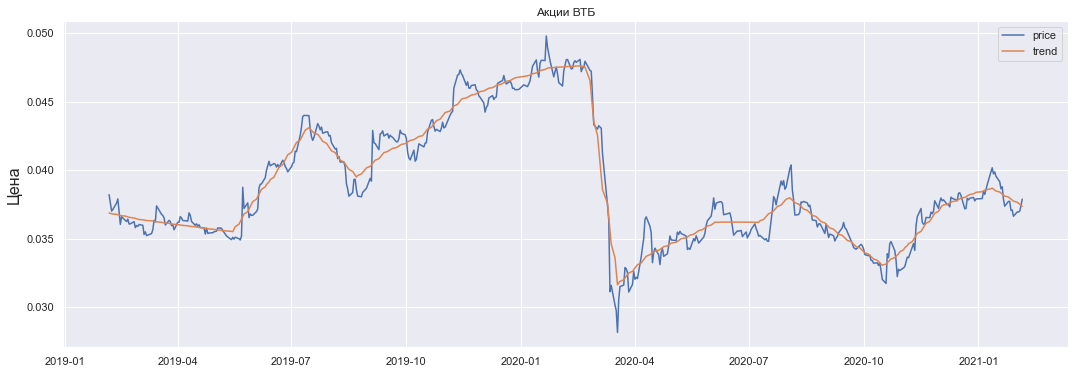

In [180]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(data["date"], data["price"], label = "price")
ax.plot(data["date"], x1, label = "trend")
ax.legend()
ax.set_title("Акции ВТБ")
ax.set_ylabel('Цена', fontsize=16)
plt.show()

### 4).

Исходная задача: $f(x) = \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 \rightarrow \min\limits_{x \in R^T}$

Заметим, что $\|x\|_1 = \max\limits_{|u| \leq 1} u^T x$
$\Rightarrow f(x) = \frac{1}{2}\|y - x\|_2^2 + \max\limits_{|u| \leq 1} \lambda u^T Dx$

Возьмем в качестве прокс функции $d(u) = \|u\|_2^2$

Тогда сглаженная версия задачи будет иметь вид:

$\widetilde{f(x)} = \frac{1}{2}\|y - x\|_2^2 + \max\limits_{|u| \leq 1} (\lambda u^T Dx - \mu \|u\|_2^2) \rightarrow \min\limits_{x \in R^T}$

$\nabla \widetilde{f(x)} = y - x + \lambda D^T u^*(x), \ u^*(x) = \operatorname*{argmax}\limits_{|u| \leq 1} \{\lambda u^T Dx - \mu \|u\|_2^2\} = \operatorname*{argmax}\limits_{\forall i \  |u_i| \leq 1} \{\sum\limits_{i=1}^n (\lambda u_i (Dx)_i - \mu u_i^2)\}=\begin{bmatrix}
\operatorname*{argmax}\limits_{|u_1| \leq 1} \{(\lambda u_1 (Dx)_1 - \mu u_1^2)\} \\
\operatorname*{argmax}\limits_{|u_2| \leq 1} \{(\lambda u_2 (Dx)_2 - \mu u_2^2)\}  \\
\vdots  \\
\operatorname*{argmax}\limits_{|u_n| \leq 1} \{(\lambda u_n (Dx)_n - \mu u_n^2)\}
\end{bmatrix}$

$g(u_i) = \lambda u_i (Dx)_i - \mu u_i^2) \rightarrow \max\limits_{|u_i| \leq 1}$

$\nabla g(u_i) = \lambda (Dx)_i - 2\mu u_i = 0 \Rightarrow u_i = \frac{\lambda (Dx)_i}{2\mu}$

Если $|\frac{\lambda (Dx)_i}{2\mu}| \leq 1$, то $\operatorname*{argmax}\limits_{|u_i| \leq 1} g(u_i) = \frac{\lambda (Dx)_i}{2\mu}$

Иначе максимум достигается на границе, то есть $|u_i| = 1$
$\Rightarrow \max\limits_{|u_i| \leq 1} = \max \{g(1), g(-1)\} = \max \{\lambda (Dx)_i - \mu, -\lambda (Dx)_i - \mu\} = \lambda |(Dx)_i| - \mu$

$\Rightarrow \begin{equation*}
 \operatorname*{argmax}\limits_{|u_i| \leq 1} \{\lambda u_i (Dx)_i - \mu u_i^2\}= 
 \begin{cases}
   \frac{\lambda (Dx)_i}{2\mu}, &\text{$|\frac{\lambda (Dx)_i}{2\mu}| \leq 1$}\\
    sign(\frac{\lambda (Dx)_i}{2\mu}), &\text{$|\frac{\lambda (Dx)_i}{2\mu}| > 1$}
 \end{cases}
\end{equation*}$

In [274]:
def opt_u(x, lam, mu):
    return np.clip(0.5*lam*D@x/mu, -1, 1)


def f(x):
    return 0.5 * (np.linalg.norm(y-x))**2 + lam * np.linalg.norm(D@x, 1)

def f_grad(x):
    return x - y + lam * D.T @ opt_u(x, lam, mu)

In [186]:
def nag(x0, num_iter, alpha):
    conv = [x0.copy()]
    x = x0.copy()
    y2 = x0.copy()
    x_prev = x0.copy()
    d = np.zeros(n)
    for i in range(1, num_iter+1):
        #### 1
        f_value = f(x)
        grad_value = f_grad(x)
        d += (i+1)/2 * grad_value
        
        #### 2
        y2 = x - alpha * grad_value
        
        #### 3
        z = -0.5*alpha * d
        
        #### 4
        x = 2/(i+3) * z + (i+1)/(i+3) * y2
        
        x_prev = x.copy()
        conv.append(x.copy())
    return x, conv

In [187]:
e = np.ones((1, n))
D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
D = D.toarray()
y = data["price"].to_numpy()
x0 = np.random.randn(n)
max_iter = 15000
alpha = 1e-5
mu = 1e-13
lam = 0.05

In [188]:
x2, conv2 = nag(x0, max_iter, alpha)

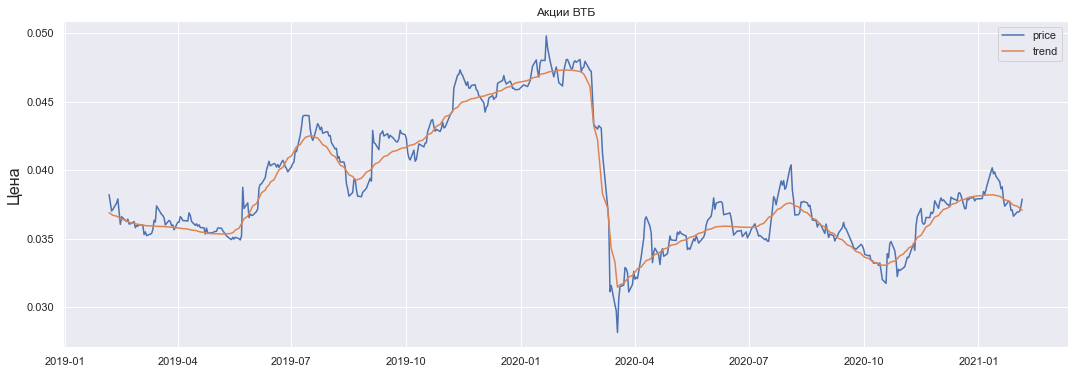

In [189]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(data["date"], data["price"], label = "price")
ax.plot(data["date"], x2, label = "trend")
ax.legend()
ax.set_title("Акции ВТБ")
ax.set_ylabel('Цена', fontsize=16)
plt.show()

### 5).

Исходная задача: $\frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 \rightarrow \min\limits_{x \in R^T}$

Перепишем в эквивалентном виде:

$\frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 \rightarrow \min\limits_{x,z \in R^T}$

$s.t. Dx - z = 0$

Модифицированный лагранжиан имеет вид: $L_{\rho}(x,z,\mu) = \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 + $
$\mu^T(Dx - z) + \frac{\rho}{2}\|Dx - z\|_2^2$

Схема ADMM:

##### 1). $x_{k+1} = \operatorname*{argmin}\limits_{x} L_{\rho}(x, z_k, \mu_k) = $
$\operatorname*{argmin}\limits_{x} \frac{1}{2}\|y - x\|_2^2 + \frac{\rho}{2} \|Dx - z_k + \frac{\mu_k}{\rho}\|_2^2$

Приравняв градиент к нулю, получаем:

$x - y + \rho D^T(Dx - z_k + \frac{\mu_k}{\rho}) = 0 \Rightarrow x_{k+1} = (\rho D^TD + I)^{-1}[y + \rho D^T(z_k-\frac{\mu_k}{\rho})]$

##### 2). $z_{k+1} = \operatorname*{argmin}\limits_{z} L_{\rho}(x_{k+1}, z, \mu_k) = $
$\operatorname*{argmin}\limits_{z} \lambda \|z\|_1 + \frac{\rho}{2} \|Dx_{k+1} - z + \frac{\mu_k}{\rho}\|_2^2$


$g(z) = \lambda \|z\|_1 + \frac{\rho}{2} \|Dx_{k+1} - z + \frac{\mu_k}{\rho}\|_2^2$

Заметим, что $g(z)$ факторизуется:

$g(z) = \sum\limits_{i} \{\lambda |z_i| + \frac{\rho}{2}(z_i - (Dx_{k+1} + \frac{\mu_k}{\rho})_i)^2\}$


Поэтому достаточно решить задачу одномерной минимизации:

$g(z_i) = \lambda |z_i| + \frac{\rho}{2}(z_i - (Dx_{k+1} + \frac{\mu_k}{\rho})_i)^2 \rightarrow \min\limits_{z_i}$

Необходимые условия оптимальности: $\lambda a(z_i) + \rho(z_i - (Dx_{k+1} + \frac{\mu_k}{\rho})_i)$, где $a(z)$ - 
субградиент $|z|$


- z_i > 0 $\Rightarrow \lambda + \rho(z_i - (Dx_{k+1} + \frac{\mu_k}{\rho})_i) = 0 $
$\Rightarrow z_i = (Dx_{k+1} + \frac{\mu_k}{\rho})_i - \frac{\lambda}{\rho}, \ (Dx_{k+1} + \frac{\mu_k}{\rho})_i > \frac{\lambda}{\rho}$

- z_i < 0 $\Rightarrow - \lambda + \rho(z_i - (Dx_{k+1} + \frac{\mu_k}{\rho})_i) = 0 $
$\Rightarrow z_i = (Dx_{k+1} + \frac{\mu_k}{\rho})_i + \frac{\lambda}{\rho}, \ (Dx_{k+1} + \frac{\mu_k}{\rho})_i < -\frac{\lambda}{\rho}$

- z_i = 0 $\Rightarrow 0 \in [\lambda, \lambda] - \rho (Dx_{k+1} + \frac{\mu_k}{\rho})_i$
$\Rightarrow \rho (Dx_{k+1} + \frac{\mu_k}{\rho})_i \in [-\lambda, \lambda]$

Итого:

\begin{equation*}
 z_i = 
 \begin{cases}
   (Dx_{k+1} + \frac{\mu_k}{\rho})_i - \frac{\lambda}{\rho}, &\text{$(Dx_{k+1} + \frac{\mu_k}{\rho})_i > \frac{\lambda}{\rho}$}\\
   (Dx_{k+1} + \frac{\mu_k}{\rho})_i + \frac{\lambda}{\rho}, &\text{$(Dx_{k+1} + \frac{\mu_k}{\rho})_i < -\frac{\lambda}{\rho}$}\\
    0, &\text{$(Dx_{k+1} + \frac{\mu_k}{\rho})_i \in [-\lambda, \lambda]$}
 \end{cases}
\end{equation*}


Но это означает, что $z_{k+1}$ это Shrinkage operator


$z_{k+1} = Sr_{\frac{\lambda}{\rho}}(Dx_{k+1} + \frac{\mu_k}{\rho})$


##### 3).

$\mu_{k+1} = \mu_k + \rho (Dx_{k+1} - z_{k+1})$

In [101]:
import scipy.linalg as splin

In [190]:
def update_x_admm(x, z, mu, D, rho, lu_factor):
    n = x.shape[0]
    return splin.lu_solve(lu_factor, y + rho * D.T.dot(z - mu/rho))

def update_z_admm(x, z, mu, D, rho, lam):
    v = D.dot(x) + mu/rho
    return np.sign(v) * np.maximum(np.zeros_like(v), np.abs(v) - lam/rho) 

In [191]:
def admm(update_x, update_z, rho0, x0, z0, mu0, max_iter, lam):
    x = x0.copy()
    z = z0.copy()
    mu = mu0.copy()
    conv_x = [x]
    conv_z = [z]
    conv_mu = [mu]
    rho = rho0
    lu_factor = splin.lu_factor(rho*D.T@D + np.eye(n))
    for i in range(max_iter):
        x = update_x(x, z, mu, D, rho, lu_factor)
        z = update_z(x, z, mu, D, rho, lam)
        mu = mu + rho * (D.dot(x) - z)
        conv_x.append(x.copy())
        conv_z.append(z.copy())
        conv_mu.append(mu.copy())
    return x, conv_x

In [192]:
y = data["price"].to_numpy()
n = y.shape[0]
e = np.ones((1, n))
D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
D = D.toarray()
x0 = np.random.randn(n)
z0 = np.random.randn(n-2)
mu0 = np.random.randn(n-2)
max_iter = 15000
rho = 10
lam = 0.05

In [193]:
x3, conv_3 = admm(update_x_admm, update_z_admm, rho, x0, z0, mu0, max_iter, lam)

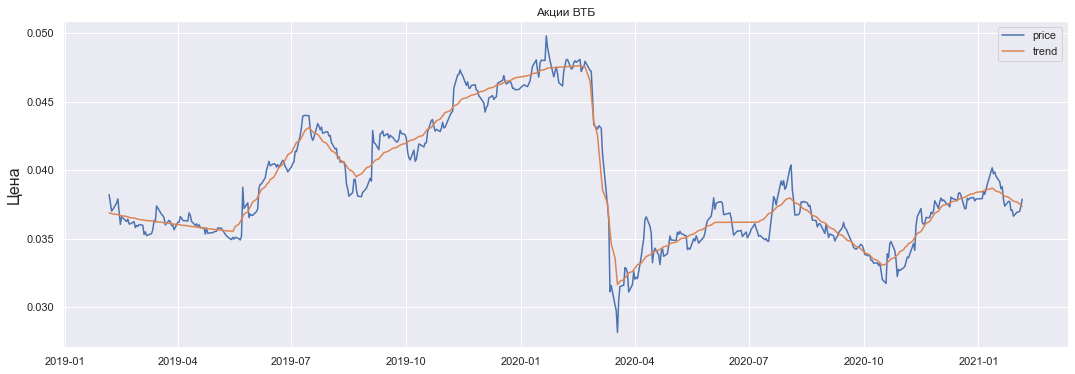

In [194]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(data["date"], data["price"], label = "price")
ax.plot(data["date"], x3, label = "trend")
ax.legend()
ax.set_title("Акции ВТБ")
ax.set_ylabel('Цена', fontsize=16)
plt.show()

### 6).

In [195]:
def f(x):
    return 0.5 * (np.linalg.norm(x-y))**2 + lam * np.linalg.norm(D.dot(x))

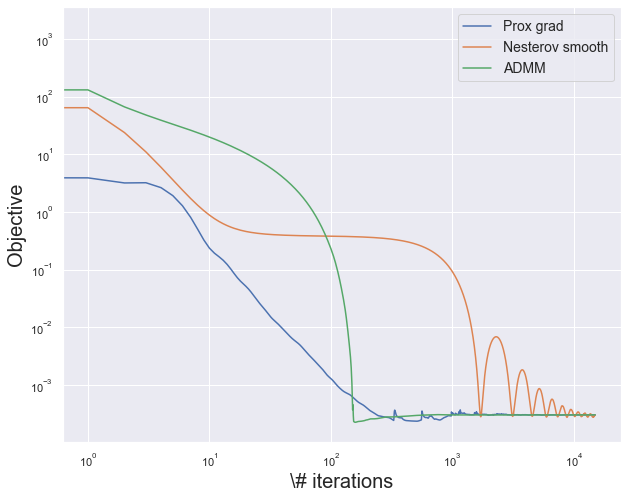

In [199]:
plt.figure(figsize=(10, 8))
plt.semilogy([f(y - D.T @ x) for x in conv1], label="Prox grad")
plt.semilogy([f(x) for x in conv2], label="Nesterov smooth")
plt.semilogy([f(x) for x in conv_3], label="ADMM")
plt.legend(fontsize=14)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("Objective", fontsize=20)
plt.show()

На тестовых данных быстрее остальных сходится проксимальный градиентный спуск, медленне всех сходится ускоренный градиентный спуск для сглаженной задачи, так же он начинает вести себя не монотонно. Но при этом видим, что после 15000 итераций у всех методов значение целевой функции примерно одинаковое.

# ADMM (15 pts)

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, с которой Вы наверняка сталкивались, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$\textbf{RegMC problem}$

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 


1. (1 pts) Сведите задачу RegMC к виду, пригодному для решения алгоритмом ADMM
2. (5 pts) Выпишите аналитическую запись всех шагов вычисления алгоритма ADMM для численного решения задачи, полученной в пункте 1.
3. (2 pts) Реализуйте метод ADMM. 
4. (1 pts) Сведите задачу RegMC к виду, пригодному для решения техникой сглаживания
5. (5 pts) Реализуйте алгоритм быстрого градиентного спуска+техника сглаживания для задачи из п.4
6. (1 pts) Протестируйте алгоритм из п.3 на тестовых данных и сравните результаты. 
От Вас требуется сравнить скорость сходимости методов на тестовых данных. Предложите метод сравнения и обоснуйте свой выбор.





### 1).

Исходная задача: 

$\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}$


Заметим, что $X_{ij} = tr(E_{ij}^T X) = \langle E_{ij}, X \rangle$

Следовательно, $X_{i,j} = Y_{i,j} \Leftrightarrow \langle E_{ij}, X - Y \rangle = 0$ - линейное ограничение

Также введем следующее обозначение:

$X_E$ - упорядоченный вектор, состоящий из $X_{ij}, \ (i,j) \in E$

Тогда задача переписывается в виде:

$\begin{align*}
& \|X \|_* \rightarrow \min\limits_X \\
& s.t. X_E = Y_E\\
\end{align*}$


Эквивалентная ей:

$\begin{align*}
& \|X \|_* + I_{X_E = Y_E}(Z)\rightarrow \min\limits_X \\
& s.t. X = Z\\
\end{align*}$

В данном виде задачу можно решать с помощью ADMM

### 2).

Модифицированный лагранжиан имеет вид:

$L_{\rho}(X, Z, \lambda) = \|X \|_* + I_{X_E = Y_E}(Z) + \langle \lambda, X - Z \rangle + $
$\frac{\rho}{2} \|X - Z\|_F^2$

Схема ADMM:

##### 1). $X_{k+1} = \operatorname*{argmin}\limits_{X} L_{\rho}(X, Z_k, \lambda_k) = \operatorname*{argmin}\limits_{X} \|X \|_* + \frac{\rho}{2}\|X - Z + \frac{1}{\rho}\lambda\|_F^2 = \operatorname*{argmin}\limits_{X} \frac{1}{\rho}\|X \|_* + \frac{1}{2}\|X - B\|_F^2,$ $B = Z - \frac{1}{\rho}\lambda$  


Поскольку ядерная норма $\|X\|_*$ является нормой, то она, очевидно, выпукла

Далее, $\frac{1}{2}\|X - B\|_F^2$ - квадратичный функционал

Поэтому, $\frac{1}{\rho}\|X \|_* + \frac{1}{2}\|X - B\|_F^2$ - сильно выпуклый функционал, следовательно минимум существует и единственен

Запишем необходимые условия оптимальности:

$0 \in X - B + \frac{1}{\rho}\partial\|X \|_*$, где $\partial\|X \|_*$ - субдифференциал ядерной нормы


Пусть сингулярное разложение для $X$ имеет вид: $X = U\Sigma V^*$, тогда


$\partial\|X \|_* = \{ UV^* + W: U^*W = 0, WV = 0, \|W\|_2 \leq 1\}$

Данная формула для субградиента взята отсюда https://people.eecs.berkeley.edu/~brecht/papers/08.Candes.Recht.MatrixCompletion.pdf (стр. 15, (3.4))


Введем следующий оператор: $D_{\tau}(X) := UD_{\tau}(\Sigma)V^*, \ D_{\tau}(\Sigma) = diag(\{(\sigma_i - \tau)_+\})$


Обозначим: $\hat{X} := D_{\rho{-1}}(X)$

Запишем SVD для $B$: $B = U_0\Sigma_0 V_0^* + U_1\Sigma_1 V_1^*$, где $U_0, V_0 (U_1, V_1)$ состоят из сингулярных векторов, соответствующих сингулярным числам, которые больше (меньше либо равны) $\rho{-1}$

Тогда $\hat{X} = U_0(\Sigma_0 - \frac{1}{\rho} I)V_0^*, \ B - \hat{X} = \frac{1}{\rho}(U_0V_0^* + W)$, где $ W = \rho U_1\Sigma_1V_1^*$

Так как в сингулярном разложении сингулярные векторы попарно ортогнальны, то $U_0^*W = 0, \ WV_0 = 0$

При этом $\|W\|_2 \leq 1$, так как в $\Sigma_1$ все диагональные элементы не больше $\rho{-1}$

Следовательно, $B - \hat{X} \in \partial\|\hat{X}\|_*$


Итого, получаем: $X_{k+1} = \operatorname*{argmin}\limits_{X} \frac{1}{\rho}\|X \|_* + \frac{1}{2}\|X - (Z - \frac{1}{\rho}\lambda)\|_F^2 = D_{\frac{1}{\rho}}(Z - \frac{1}{\rho}\lambda)$


##### 2). $Z_{k+1} = \operatorname*{argmin}\limits_{Z} L_{\rho}(X_{k+1}, Z, \lambda_k) = \operatorname*{argmin}\limits_{Z: Z_E = Y_E} \|X + \frac{1}{\rho}\lambda - Z\|_F^2 = \operatorname*{argmin}\limits_{Z: Z_E = Y_E} \{\sum\limits_{i,j \in E} (X + \frac{1}{\rho}\lambda - Z)_{ij}^2 + \sum\limits_{i,j \not\in E} (X + \frac{1}{\rho}\lambda - Z)_{ij}^2\}$


$\Rightarrow Z_{k+1} = \begin{equation*}
 \begin{cases}
   Y_{ij} &\text{$(i,j) \in E$}\\
   (X + \frac{1}{\rho}\lambda)_{ij} &\text{$(i,j) \not\in E$}
 \end{cases}
\end{equation*}$



##### 3). $\lambda_{k+1} = \lambda_{k} + \rho (X_{k+1} - Z_{k+1})$

### 3).

В качестве тестовых данных возьем сначала черно-белые картинки и нанесем на них шум

In [4]:
import cv2

In [156]:
def f(x):
    u, s, v = np.linalg.svd(x)
    return np.sum(x)

In [193]:
def g(x):
    return np.linalg.norm(img-x)

In [10]:
def update_x_admm(x, z, lam, rho):
    u, s, v = np.linalg.svd(z - lam/rho, full_matrices = False)
    s = np.maximum(np.zeros_like(s), s - 1/rho) 
    return u @ np.diag(s) @ v

def update_z_admm(x, z, lam, M, rho, mask):    
    return (x + lam/rho)*mask + M

In [134]:
def admm(update_x, update_z, rho0, x0, z0, lam0, max_iter, M, mask):
    x = x0.copy()
    z = z0.copy()
    lam = lam0.copy()
    conv_x = [x]
    conv_z = [z]
    conv_lam = [lam]
    rho = rho0
    for i in range(max_iter):
        #print(i)
        x = update_x(x, z, lam, rho)
        z = update_z(x, z, lam, M, rho, mask)
        lam = lam + rho * (x - z)
        conv_x.append(x.copy())
        conv_z.append(z.copy())
        conv_lam.append(lam.copy())
    return x, conv_x

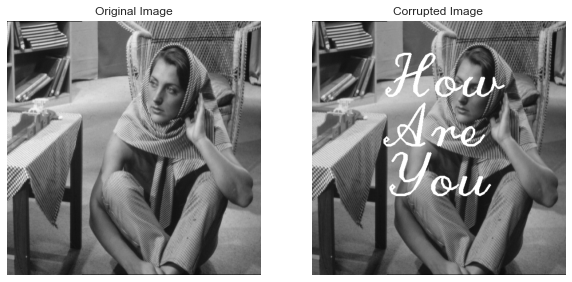

In [153]:
img = cv2.imread('/Users/arsenij/Downloads/sem_05_knn/data/barbara.jpg', 0)
img1 = img.copy()
text = "How\nAre\nYou"

y_start = 150

y_increment = 100

for i, line in enumerate(text.split('\n')):
    y = y_start + i*y_increment
    cv2.putText(img=img1, text=line, org=(150, y), fontFace=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, fontScale=4, color=(255,255,0), 
    thickness=3)
    
M = np.zeros(img.shape)
mask = np.ones(img.shape)
for i in range(512):
    for j in range(512):
        if img[i, j] == img1[i, j]:
            M[i, j] = img[i, j]
            mask[i, j] = 0
       

            
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img1, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [175]:
n = 512
x0 = img1.copy()
z0 = np.random.randn(n, n)
lam0 = np.random.randn(n, n)
max_iter = 1000
rho = 0.05

In [176]:
x, conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M, mask)

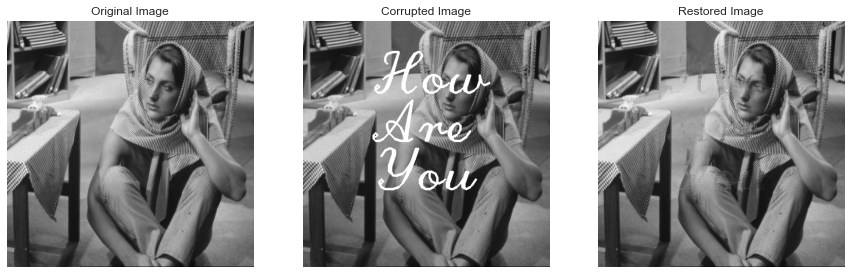

In [177]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img1, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(x, cmap='gray');
ax[2].set_title("Restored Image")
ax[2].axis('off');

Построим график зависимости евклидова расстояния от исходного изображения до текущего в зависимости от числа итераций

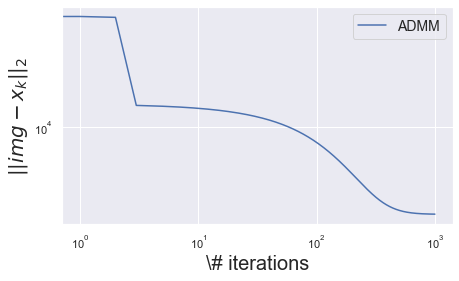

In [211]:
plt.figure(figsize=(7, 4))
plt.semilogy([g(x) for x in conv], label="ADMM")
plt.legend(fontsize=14)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\||img - x_k\||_2$", fontsize=20)
plt.show()

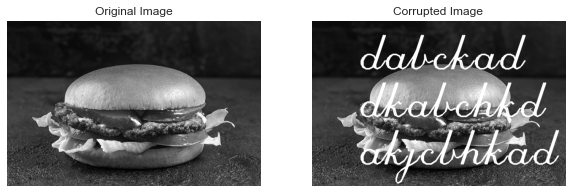

In [66]:
img = cv2.imread('/Users/arsenij/Documents/pictures/burger.jpg', 0)
img1 = img.copy()
text = "dabckad\ndkabchkd\nakjcbhkad"

y_start = 150

y_increment = 150

for i, line in enumerate(text.split('\n')):
    y = y_start + i*y_increment
    cv2.putText(img=img1, text=line, org=(150, y), fontFace=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, fontScale=5, color=(255,255,0), 
    thickness=3)
    
M = np.zeros(img.shape)
mask = np.ones(img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i, j] == img1[i, j]:
            M[i, j] = img[i, j]
            mask[i, j] = 0
       

            
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img1, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [55]:
img.shape

(520, 800)

In [74]:
x0 = np.random.randn(img.shape[0], img.shape[1])
z0 = np.random.randn(img.shape[0], img.shape[1])
lam0 = np.random.randn(img.shape[0], img.shape[1])
max_iter = 1000
rho = 0.05

In [75]:
x, conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M, mask)

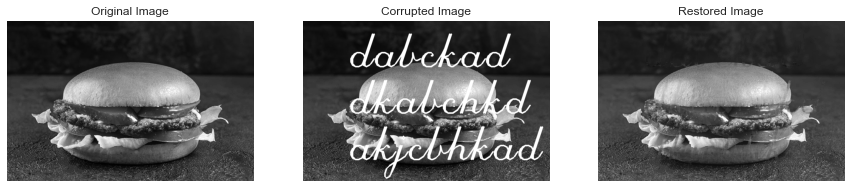

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img1, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(x, cmap='gray');
ax[2].set_title("Restored Image")
ax[2].axis('off');

Теперь попробуем потестить admm на цветных изображениях. Вообще говоря, цветное изображение - это уже не матрица, а тензор, но его можно рассматривать просто как набор трех матриц. Поэтому просто запустим метод для каждой такой матрицы, а затем полученные матрицы объеденим в тензор и выведем

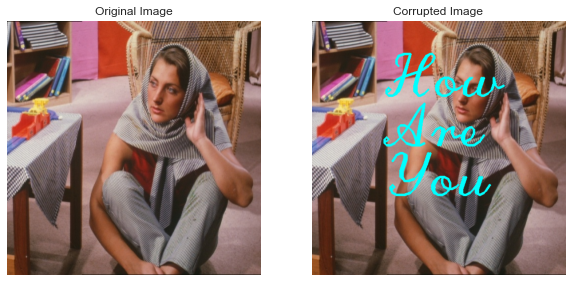

In [136]:
img = cv2.imread('/Users/arsenij/Downloads/sem_05_knn/data/barbara.jpg', 1)
img1 = img.copy()
text = "How\nAre\nYou"

y_start = 150

y_increment = 100

for i, line in enumerate(text.split('\n')):
    y = y_start + i*y_increment
    cv2.putText(img=img1, text=line, org=(150, y), fontFace=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, fontScale=4, color=(255,255,0), 
    thickness=3)

M = img.copy()
mask = np.ones(img.shape)
for k in range(3):
    for i in range(512):
        for j in range(512):
            if img[i, j, k] == img1[i, j, k]:
                M[i, j, k] = img[i, j, k]
                mask[i, j, k] = 0
            else:
                M[i, j, k] = 0
            
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB));
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [139]:
n = 512
x0 = np.random.randn(n, n)
z0 = np.random.randn(n, n)
lam0 = np.random.randn(n, n)
max_iter = 1000
rho = 0.05

In [140]:
x = img1.copy()

In [141]:
x[:,:,0], conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M[:,:,0], mask[:, :, 0])
x[:,:,1], conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M[:,:,1], mask[:, :, 1])
x[:,:,2], conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M[:,:,2], mask[:, :, 2])

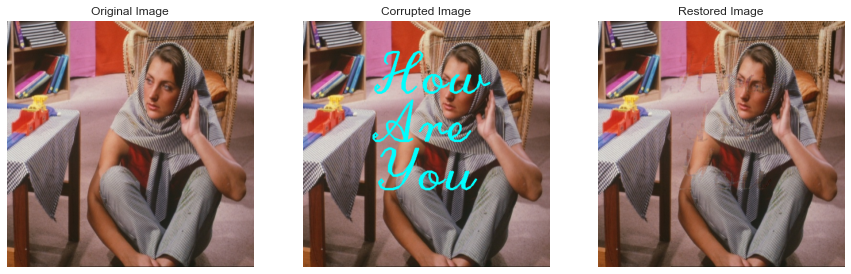

In [144]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB));
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB));
ax[2].set_title("Restored Image")
ax[2].axis('off');

In [146]:
img.shape

(520, 800)

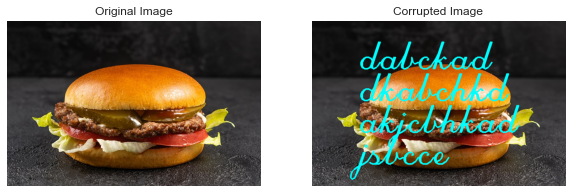

In [148]:
img = cv2.imread('/Users/arsenij/Documents/pictures/burger.jpg', 1)
img1 = img.copy()
text = "dabckad\ndkabchkd\nakjcbhkad\njsbcce"

y_start = 150

y_increment = 100

for i, line in enumerate(text.split('\n')):
    y = y_start + i*y_increment
    cv2.putText(img=img1, text=line, org=(150, y), fontFace=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, fontScale=4, color=(255,255,0), 
    thickness=3)

M = img.copy()
mask = np.ones(img.shape)
for k in range(3):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j, k] == img1[i, j, k]:
                M[i, j, k] = img[i, j, k]
                mask[i, j, k] = 0
            else:
                M[i, j, k] = 0
            
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB));
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [149]:
x0 = np.random.randn(img.shape[0], img.shape[1])
z0 = np.random.randn(img.shape[0], img.shape[1])
lam0 = np.random.randn(img.shape[0], img.shape[1])
max_iter = 1000
rho = 0.05

In [150]:
x = img1.copy()

In [151]:
x[:,:,0], conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M[:,:,0], mask[:, :, 0])
x[:,:,1], conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M[:,:,1], mask[:, :, 1])
x[:,:,2], conv = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M[:,:,2], mask[:, :, 2])

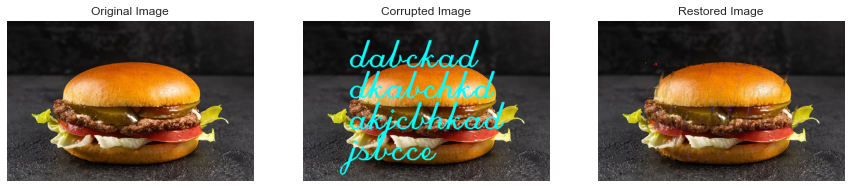

In [152]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB));
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB));
ax[2].set_title("Restored Image")
ax[2].axis('off');

### 4).

##### 1.
Поскольку спектральная норма является сопряженной для ядерной, то выполнено равенство:

$h(X) = \|X\|_* = \max\limits_{\|Y\|_2 \leq 1} \langle X, Y \rangle$

Тогда сглаженная версия имеет вид: $h_{\mu}(X) = \max\limits_{\|Y\|_2 \leq 1} \{\langle X, Y \rangle - \frac{\mu}{2} \|Y\|_F^2\}$

$\nabla h_{\mu}(X) = Y^*(X)$

Пусть сингулярное разложение для $X$ имеет вид: $X = U \Sigma V^*$

Для $Y$: $Y = U_1 \Sigma_1 V_1^*$

Тогда $\langle X, Y \rangle - \frac{\mu}{2} \|Y\|_F^2 = \langle X, Y \rangle - \frac{\mu}{2} \sum\limits_i \sigma_i^2(Y) \leq \{ Неравенство\  Фон-Неймана \ для\  следа\} \leq$
$\sum\limits_i \sigma_i(X) \sigma_i(Y) - \frac{\mu}{2} \sum\limits_i \sigma_i^2(Y)$

При этом равенство достигается, например, при $Y = U \Sigma_1 V^*$, так как $\langle X, Y \rangle = $
$tr(X^* Y) = tr(V\Sigma U^* U \Sigma_1 V^*) = \sum\limits_i \sigma_i(X) \sigma_i(Y)$

То есть при фиксированных сингулярных числах, сингулярные векторы у $Y$ должны быть такими же, как у $X$.

Поэтому задача свелась к поиску сингулярных чисел:

$\sum\limits_i \{\sigma_i(X) \sigma_i(Y) - \frac{\mu}{2} \sigma_i^2(Y)\} \rightarrow \max\limits_{|\sigma_i(Y)| \leq 1}$

При этом задача факторизуется, поэтому достаточно решить одномерную:

$f(\sigma_i(Y)) = \sigma_i(Y) \sigma_i(X) - \frac{\mu}{2} \sigma_i(Y)^2 \rightarrow \max\limits_{|\sigma_i(Y)| \leq 1}$

$\nabla f = \sigma_i(X) - \mu \sigma_i(Y) = 0 \Rightarrow \sigma_i(Y) = \frac{\sigma_i(X)}{\mu}$

Если $\frac{\sigma_i(X)}{\mu} < 1$, то данная точка внутренняя и при этом градиент в ней равен нулю, поэтому в ней достигается максимум 

Иначе максимум достигается на границе, то есть $\sigma_i(Y) = 1$

$\Rightarrow \nabla h_\mu(X) = Y^*(X) = U \Sigma_1 V^*$, где $\sigma_i(Y) = \min \{\frac{\sigma_i(X)}{\mu}, 1\}$


##### 2.

$M_E$ - известные элементы матрицы

$Y_{k} = \operatorname*{argmin}\limits_{X_E = M_E} \{ \langle \nabla h_\mu(X_k), X - X_k \rangle - \frac{L}{2} \|X - X_k\|_F^2\} = $

$= \operatorname*{argmin}\limits_{X: X_E = M_E} \{\sum\limits_{i,j \in E} [\nabla h_\mu(X_k)_{ij} X_{ij} - \frac{L}{2} (X - X_k)_{ij}^2] + \sum\limits_{i,j \not\in E} [\nabla h_\mu(X_k)_{ij} X_{ij} - \frac{L}{2} (X - X_k)_{ij}^2]\}$


$\Rightarrow Y_{k} = \begin{equation*}
 \begin{cases}
   M_{ij} &\text{$(i,j) \in E$}\\
   X_k - \frac{1}{L}\nabla (h_\mu(X_k))_{ij} &\text{$(i,j) \not\in E$}
 \end{cases}
\end{equation*}$



##### 3).

$Z_{k} = \operatorname*{argmin}\limits_{X_E = M_E} \{\frac{L}{\sigma_1} \|X\|_F^2 + \sum\limits_{i=1}^k \frac{i+1}{2} [h_\mu(X) + \langle \nabla h_\mu(X_i), X - X_i \rangle]\}$

Аналогично предыдущему пункту:

$Z_{k} = \begin{equation*}
 \begin{cases}
   M_{ij} &\text{$(i,j) \in E$}\\
   X_k - \frac{\sigma_1}{2L} \sum\limits_{l=1}^k \frac{i+1}{2} \nabla (h_\mu(X_l))_{ij} &\text{$(i,j) \not\in E$}
 \end{cases}
\end{equation*}$



##### 4).

$X_{k+1} = \frac{2}{k+3} Z_k + \frac{k+1}{k+3} Y_k$

### 5).

In [213]:
def opt_u(x, mu):
    u, s, v = np.linalg.svd(x/mu, full_matrices = False)
    s = np.clip(s, 0, 1)
    return u @ np.diag(s) @ v


def f(x):
    return 0.5 * (np.linalg.norm(y-x))**2 + lam * np.linalg.norm(D@x, 1)

def f_grad(x):
    return opt_u(x, mu)

In [259]:
def nag(x0, num_iter, alpha, mask, M):
    conv = [x0.copy()]
    x = x0.copy()
    y2 = x0.copy()
    x_prev = x0.copy()
    d = np.zeros_like(x0)
    for i in range(1, num_iter+1):
        #print(i)
        #### 1
        #f_value = f(x)
        grad_value = f_grad(x)
        d += (i+1)/2 * grad_value
        
        #### 2
        y2 = (x - alpha * grad_value) * mask + M
        
        #### 3
        z = -0.5*alpha * d
        z2 = z * mask + M
        
        #### 4
        x = 2/(i+3) * z2 + (i+1)/(i+3) * y2
        
        x_prev = x.copy()
        conv.append(x.copy())
    return x, conv

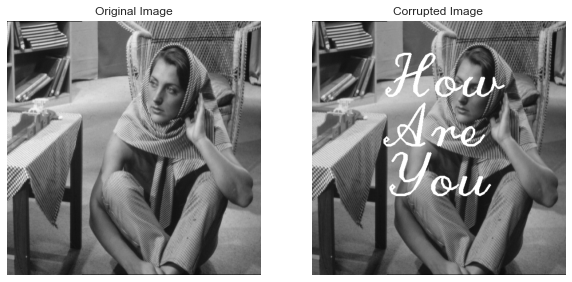

In [260]:
img = cv2.imread('/Users/arsenij/Downloads/sem_05_knn/data/barbara.jpg', 0)
img1 = img.copy()
text = "How\nAre\nYou"

y_start = 150

y_increment = 100

for i, line in enumerate(text.split('\n')):
    y = y_start + i*y_increment
    cv2.putText(img=img1, text=line, org=(150, y), fontFace=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, fontScale=4, color=(255,255,0), 
    thickness=3)
    
M = np.zeros(img.shape)
mask = np.ones(img.shape)
for i in range(512):
    for j in range(512):
        if img[i, j] == img1[i, j]:
            M[i, j] = img[i, j]
            mask[i, j] = 0
       

            
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img1, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [261]:
n = 512
x0 = np.random.randn(n, n)
z0 = np.random.randn(n, n)
lam0 = np.random.randn(n, n)
max_iter = 1500
alpha = 1e-0
mu = 1e-1

In [262]:
x, conv = nag(x0, max_iter, alpha, mask, M)

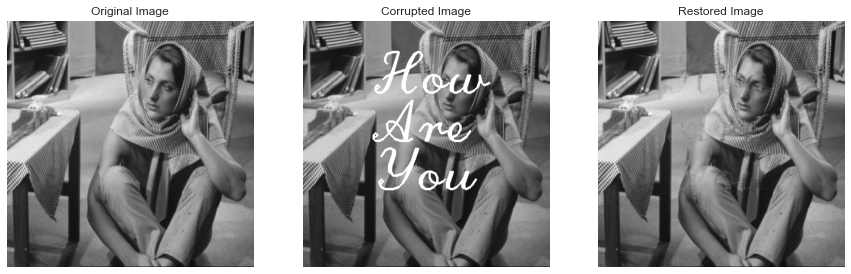

In [264]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img1, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(x, cmap='gray');
ax[2].set_title("Restored Image")
ax[2].axis('off');

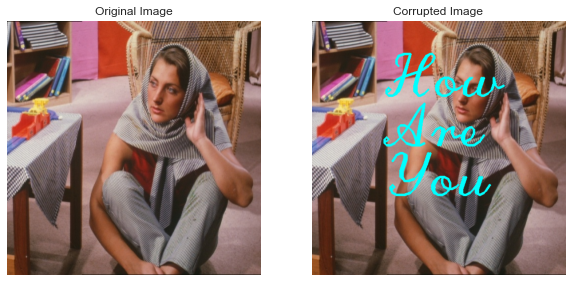

In [265]:
img = cv2.imread('/Users/arsenij/Downloads/sem_05_knn/data/barbara.jpg', 1)
img1 = img.copy()
text = "How\nAre\nYou"

y_start = 150

y_increment = 100

for i, line in enumerate(text.split('\n')):
    y = y_start + i*y_increment
    cv2.putText(img=img1, text=line, org=(150, y), fontFace=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, fontScale=4, color=(255,255,0), 
    thickness=3)

M = img.copy()
mask = np.ones(img.shape)
for k in range(3):
    for i in range(512):
        for j in range(512):
            if img[i, j, k] == img1[i, j, k]:
                M[i, j, k] = img[i, j, k]
                mask[i, j, k] = 0
            else:
                M[i, j, k] = 0
            
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB));
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [ ]:
n = 512
x0 = np.random.randn(n, n)
z0 = np.random.randn(n, n)
lam0 = np.random.randn(n, n)
max_iter = 1500
alpha = 1e-0
mu = 1e-1

In [266]:
x = img1.copy()
x[:,:,0], conv = nag(x0, max_iter, alpha, mask[:,:,0], M[:,:,0])
x[:,:,1], conv = nag(x0, max_iter, alpha, mask[:,:,1], M[:,:,1])
x[:,:,2], conv = nag(x0, max_iter, alpha, mask[:,:,2], M[:,:,2])

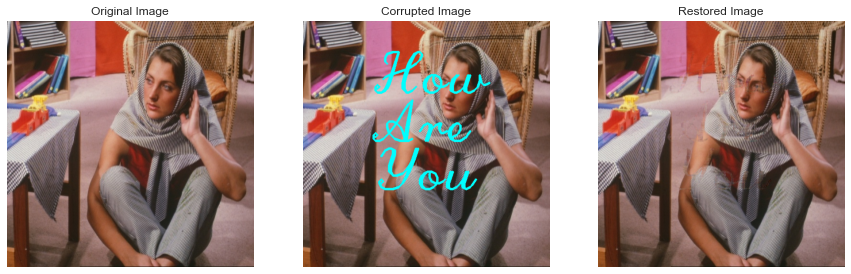

In [267]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB));
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB));
ax[2].set_title("Restored Image")
ax[2].axis('off');

##### 6).



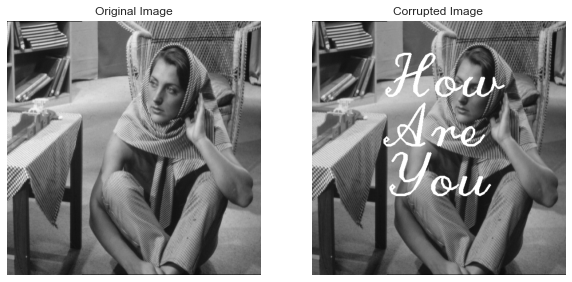

In [269]:
img = cv2.imread('/Users/arsenij/Downloads/sem_05_knn/data/barbara.jpg', 0)
img1 = img.copy()
text = "How\nAre\nYou"

y_start = 150

y_increment = 100

for i, line in enumerate(text.split('\n')):
    y = y_start + i*y_increment
    cv2.putText(img=img1, text=line, org=(150, y), fontFace=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, fontScale=4, color=(255,255,0), 
    thickness=3)
    
M = np.zeros(img.shape)
mask = np.ones(img.shape)
for i in range(512):
    for j in range(512):
        if img[i, j] == img1[i, j]:
            M[i, j] = img[i, j]
            mask[i, j] = 0
       

            
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(img1, cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [270]:
n = 512
x0 = np.random.randn(n, n)
z0 = np.random.randn(n, n)
lam0 = np.random.randn(n, n)
max_iter = 2000
rho = 0.05
alpha = 1e-0
mu = 1e-1

In [271]:
x_admm, conv_admm = admm(update_x_admm, update_z_admm, rho, x0, z0, lam0, max_iter, M, mask)
x_nag, conv_nag = nag(x0, max_iter, alpha, mask, M)

Построим график зависимости евклидова расстояния от исходного изображения до текущего в зависимости от числа итераций для каждого метода

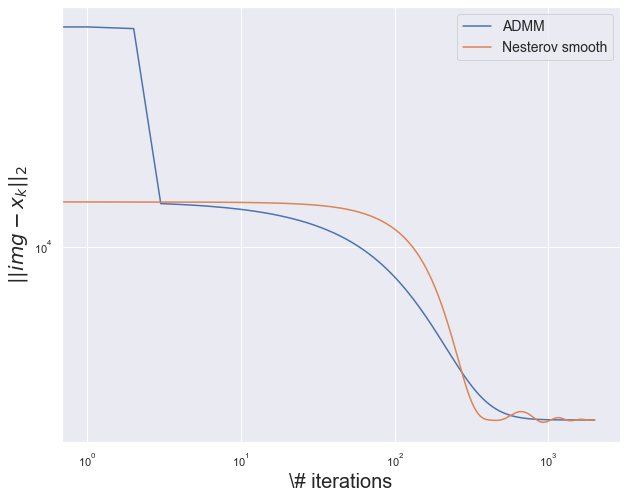

In [272]:
plt.figure(figsize=(10, 8))
plt.semilogy([g(x) for x in conv_admm], label="ADMM")
plt.semilogy([g(x) for x in conv_nag], label="Nesterov smooth")
plt.legend(fontsize=14)
plt.xscale("log")
plt.xlabel("\# iterations", fontsize=20)
plt.ylabel("$\||img - x_k\||_2$", fontsize=20)
plt.show()

Из графика видно, что ускоренный градиентный метод сглаженной задачи сошелся чуть быстрее, чем ADMM